In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image, display
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19


# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

### 데이터 로드

In [4]:
webtoon_data = pd.read_csv("webtoon_crawing.csv", names=['idx', 'title', 'summary', 'artists', 'image', 'score', 'link', 'platform', 'day', 'token'])
webtoon_data[['idx', 'title', 'image']]

,idx,title,image
0,1,학사재생,http://t1.daumcdn.net/webtoon/op/4c7ff80e90f5b...
1,2,환율이 바뀌었나요?,http://t1.daumcdn.net/webtoon/op/8b741218833a0...
2,3,무지개다리 파수꾼,http://t1.daumcdn.net/webtoon/op/dcd135a2c174a...
3,4,서천화원,http://t1.daumcdn.net/webtoon/op/32b8f0f912f46...
4,5,승리호,http://t1.daumcdn.net/webtoon/op/4adff6babda1e...
...,...,...,...
2466,2467,AA,https://shared-comic.pstatic.net/thumb/webtoon...
2467,2468,사랑in,https://shared-comic.pstatic.net/thumb/webtoon...
2468,2469,까뱅,https://shared-comic.pstatic.net/thumb/webtoon...
2469,2470,와탕카,https://shared-comic.pstatic.net/thumb/webtoon...


### 이미지 저장

In [77]:
base_image_path = keras.utils.get_file("{}.jpg".format(webtoon_data['idx'][0]), webtoon_data['image'][0])

In [78]:
reference_image_ls = []
for i in range(len(webtoon_data['image'][1:])):
    style_reference_image_path = keras.utils.get_file(
        "{}.jpg".format(webtoon_data['idx'][i]), webtoon_data['image'][i]
    )
    reference_image_ls.append(style_reference_image_path)

### 이미지 사이즈 정의

In [80]:
# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


### 이미지 출력 테스트

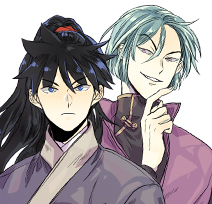

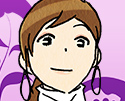

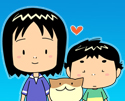

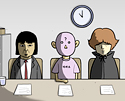

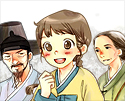

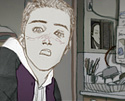

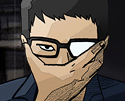

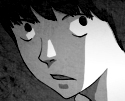

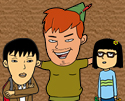

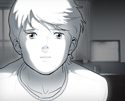

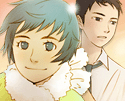

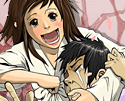

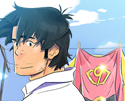

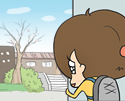

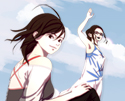

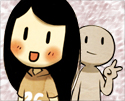

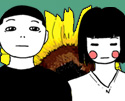

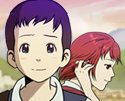

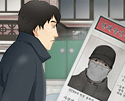

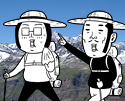

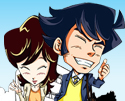

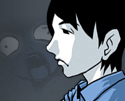

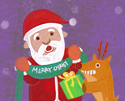

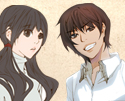

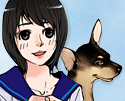

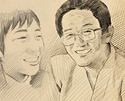

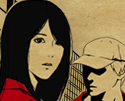

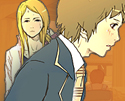

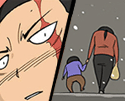

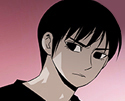

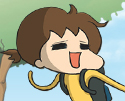

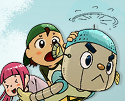

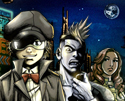

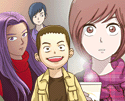

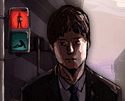

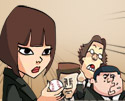

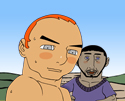

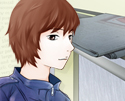

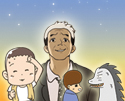

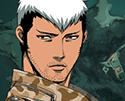

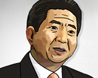

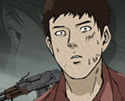

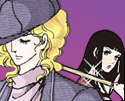

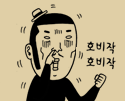

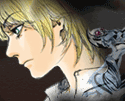

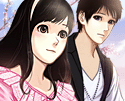

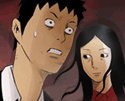

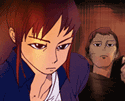

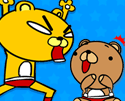

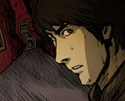

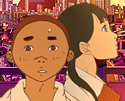

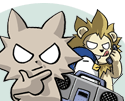

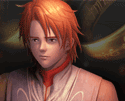

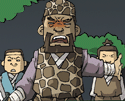

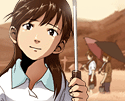

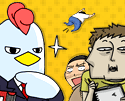

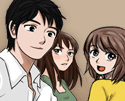

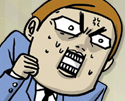

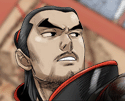

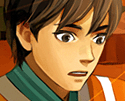

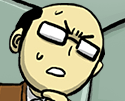

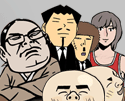

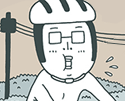

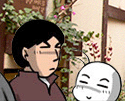

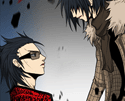

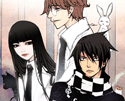

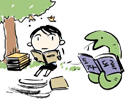

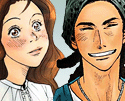

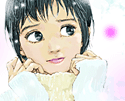

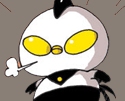

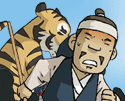

In [81]:
from IPython.display import Image, display

display(Image(base_image_path))

for i in range(2400, len(reference_image_ls)):
    display(Image(reference_image_ls[i]))


## Image preprocessing / deprocessing utilities


In [7]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


In [8]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).


In [9]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


Finally, here's the code that computes the style transfer loss.


In [10]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.


In [11]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



In [13]:
def similarity(reference_image):
    optimizer = keras.optimizers.SGD(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
        )
    )

    base_image = preprocess_image(base_image_path)
    style_reference_image = preprocess_image(reference_image)
    combination_image = tf.Variable(preprocess_image(base_image_path))

    iterations = 1
    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(
            combination_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, combination_image)])
#         display(Image(base_image_path))
#         display(Image(reference_image))
#         print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
#         fname = result_prefix + "_at_iteration_%d.png" % i
#         keras.preprocessing.image.save_img(fname, img)
    return loss

### 반복문으로 하나씩 비교

In [14]:
result = []

for i in tqdm(range(0, 100)):
    loss = similarity(reference_image_ls[i])
#     print(webtoon_data['title'].loc[i])
    
    result.append([webtoon_data['idx'].loc[i], webtoon_data['title'].loc[i], int(loss)])

  0%|          | 0/100 [00:00<?, ?it/s]

### csv 파일로 저장(200개 넘어가면 커널이 다운되어서 수동으로 200개씩 끊어서 저장함)

In [3]:
df_result = pd.DataFrame(result, columns=['idx', 'title', 'loss'])
df_result.to_csv("result12.csv")

NameError: name 'result' is not defined

# 스타일 비교

### 데이터 로드

In [5]:
style = pd.read_csv("style_compare.csv", index_col="idx")
data = style[['title', 'loss']]

### loss값 MinMaxScaler

In [6]:
arr = data['loss'].values
scale_loss = MinMaxScaler().fit_transform(arr.reshape(-1,1))

scale_loss

array([[0.        ],
       [0.0569913 ],
       [0.04133915],
       ...,
       [0.10573499],
       [0.08156056],
       [0.0727846 ]])

### scale된 컬럼 추가

In [17]:
data['scale_loss'] = scale_loss
sorted_data = data.sort_values(by=['idx'], axis=0)
sorted_data

,title,loss,scale_loss
idx,,,
1,학사재생,7812,0.000000
2,환율이 바뀌었나요?,37691,0.056991
3,무지개다리 파수꾼,29485,0.041339
4,서천화원,37410,0.056455
5,승리호,49976,0.080424
...,...,...,...
2466,도자기,56736,0.093318
2467,AA,60190,0.099906
2468,사랑in,63246,0.105735


### csv 파일로 저장

In [18]:
sorted_data.to_csv("scale_loss.csv")

### scale_loss 기준으로 데이터 정렬 후 테스트

In [10]:
sorted_data = sorted_data.sort_values(by=['loss'], axis=0, ascending=False)


similar_webtoons = sorted_data[['title', 'scale_loss']][:10]
unsimilar_webtoons = sorted_data[['title', 'scale_loss']][-11:-1]
sorted_data

,title,loss,scale_loss
idx,,,
747,소년 가라사대,532085,1.000000
2261,월남특급,373355,0.697238
1542,학교정벌,367161,0.685423
1214,바이러스X,256718,0.474764
1961,이말년씨리즈 2018,250074,0.462091
...,...,...,...
67,백의사자,15408,0.014489
328,승은이 망극하옵니다,15247,0.014182
329,소년이여,14937,0.013590


### 기준 웹툰 (학사재생)

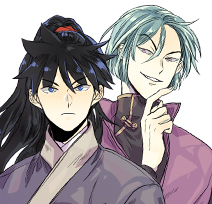

In [11]:
base_style_image_path = keras.utils.get_file(
        "{}.jpg".format(webtoon_data['idx'][0]),webtoon_data['image'][0]
    )

display(Image(base_style_image_path))

### 학사 재생과 그림체가 다른 웹툰

In [12]:
reference_image_ls = []
for i in range(len(similar_webtoons)):
    idx = webtoon_data[['idx', 'title', 'image']].iloc[similar_webtoons.index[i]-1]['idx']
    image_path = webtoon_data[['idx', 'title', 'image']].iloc[similar_webtoons.index[i]-1]['image']

    style_reference_image_path = keras.utils.get_file(
        "{}.jpg".format(idx),image_path
    )
    reference_image_ls.append(style_reference_image_path)

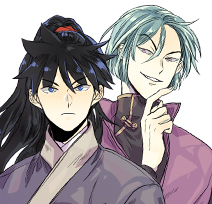

학사재생


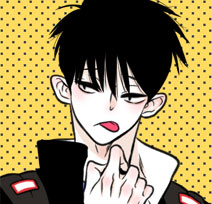

소년 가라사대


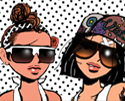

월남특급


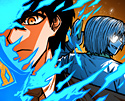

학교정벌


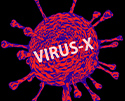

바이러스X


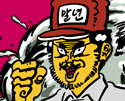

이말년씨리즈 2018


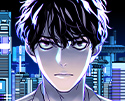

AI가 세상을 지배한다면


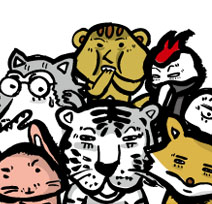

2015 동물농장


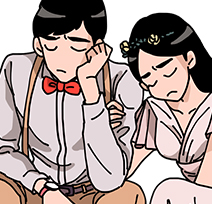

내 자식의 사생활


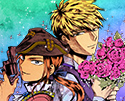

캡틴 비앙카


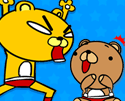

내일은 럭키곰스타


In [13]:
display(Image(base_style_image_path))
print("학사재생")

print("================================================")

for i in range(len(similar_webtoons)):
    idx = webtoon_data[['idx', 'title', 'image']].iloc[similar_webtoons.index[i]-1]['idx']
    title = webtoon_data[['idx', 'title', 'image']].iloc[similar_webtoons.index[i]-1]['title']
    image_path = webtoon_data[['idx', 'title', 'image']].iloc[similar_webtoons.index[i]-1]['image']
    display(Image(reference_image_ls[i]))
    print(title)

### 학사재생과 그림체 비슷한 웹툰

In [14]:
reference_unsimilar_image_ls = []
for i in range(len(unsimilar_webtoons)):
    idx = webtoon_data[['idx', 'title', 'image']].iloc[unsimilar_webtoons.index[i]-1]['idx']
    image_path = webtoon_data[['idx', 'title', 'image']].iloc[unsimilar_webtoons.index[i]-1]['image']

    style_reference_image_path = keras.utils.get_file(
        "{}.jpg".format(idx),image_path
    )
    reference_unsimilar_image_ls.append(style_reference_image_path)

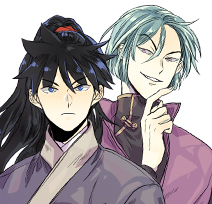

학사재생


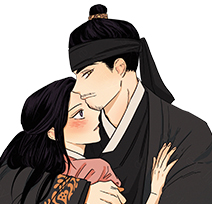

애신록


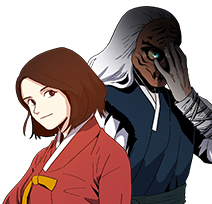

호아전


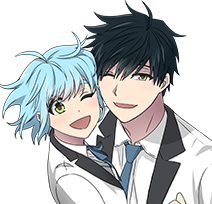

헬로 마이 안드로이드


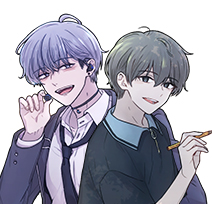

글과 그림 사이


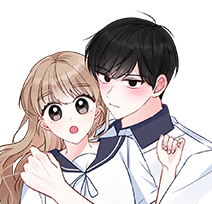

하나밖에 안 보여!


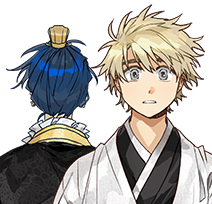

태양의 시


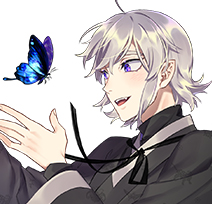

백의사자


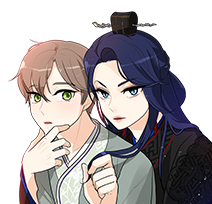

승은이 망극하옵니다


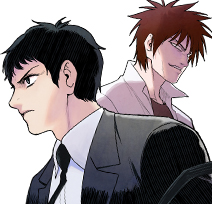

소년이여


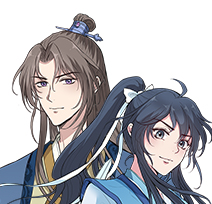

남궁세가 소공자


In [15]:
display(Image(base_style_image_path))
print("학사재생")

print("================================================")

for i in range(len(unsimilar_webtoons)):
    idx = webtoon_data[['idx', 'title', 'image']].iloc[unsimilar_webtoons.index[i]-1]['idx']
    title = webtoon_data[['idx', 'title', 'image']].iloc[unsimilar_webtoons.index[i]-1]['title']
    image_path = webtoon_data[['idx', 'title', 'image']].iloc[unsimilar_webtoons.index[i]-1]['image']
    display(Image(reference_unsimilar_image_ls[i]))
    print(title)